# GeoSTAD Synthetic Data Pipeline Test

This notebook demonstrates the complete pipeline for generating and evaluating synthetic business location data from the GeoSTAD dataset.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from synlab.data import load_geostad, prepare_for_synthesis, GeoSTADConfig
from synlab.methods import DPMMMSTSynthesizer, DPMMMSTConfig
from synlab.evaluation import (
    compare_basic_stats,
    compare_category_frequencies,
    evaluate_spatial_metrics
)

sns.set_theme()
pd.set_option('display.max_columns', None)

In [2]:
# Auto-reload modules when they change (no need to restart kernel!)
%load_ext autoreload
%autoreload 2

print("✓ Auto-reload enabled - synlab modules will update automatically")

✓ Auto-reload enabled - synlab modules will update automatically


## 2. Load GeoSTAD Data

In [3]:
# Create config and load the real business data
config = GeoSTADConfig()
df_real, domain = load_geostad(config)

print(f"Loaded {len(df_real):,} businesses")
print(f"\nColumns: {df_real.columns.tolist()}")
print(f"\nDomain info:")
for key, value in domain.items():
    if key == 'coordinate_bounds':
        print(f"  {key}: X=[{value['X_min']:.0f}, {value['X_max']:.0f}], Y=[{value['Y_min']:.0f}, {value['Y_max']:.0f}]")
    elif key == 'spatial_info':
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {len(value) if isinstance(value, dict) else value}")

Filtered to geocoded businesses: 770,568 / 2,252,561 rows
Removed 735 duplicate rows: 769,833 rows remaining
Loaded 769,833 businesses

Columns: ['SN2025', 'orgf2025', 'X_2025', 'Y_2025', 'orgn2025', 'navn2025']

Domain info:
  column_types: 6
  coordinate_bounds: X=[-74800, 1098272], Y=[6449850, 8685966]
  categorical_info: 2
  spatial_info: {}


In [4]:
# Preview the data
df_real.head(10)

,SN2025,orgf2025,X_2025,Y_2025,orgn2025,navn2025
2,90.020,NUF,199000.599174,6.625211e+06,999557244,SOUNDS LIKE NORWAY
3,46.739,AS,288582.250106,6.673567e+06,933735842,GAUSDAL LANDHANDLERI AS
4,68.209,AS,101858.577550,6.467710e+06,999666337,RAFFINERITOMTA EVJE AS
22,49.410,AS,296513.358383,6.670597e+06,925554243,B & Y TRANSPORT AS
25,49.410,AS,-31333.969165,6.742430e+06,999657273,PJT AS
31,62.030,AS,262233.386861,6.648906e+06,911625504,KIRKEPARTNER AS
36,59.110,AS,193941.634284,6.567887e+06,999553435,HULDRA FILM AS
37,41.200,AS,274506.964493,6.911902e+06,999646956,FÅDAL BYGG AS
40,62.030,NUF,271904.466914,6.654436e+06,996345734,NETS BRANCH NORWAY
51,41.200,AS,265351.511278,6.650927e+06,999654592,LENTUS BYGG AS


## 3. Prepare Features for Synthesis

In [10]:
# Select feature columns (excluding identifiers)
# Use ALL data for training (remove sample_size or set to None for full dataset)
# For testing: sample_size=5000, For production: sample_size=None
df_features = prepare_for_synthesis(df_real, config, sample_size=None, random_state=42)

print(f"Feature data: {df_features.shape}")
print(f"Columns: {df_features.columns.tolist()}")
print(f"Using {len(df_features):,} businesses for training")

df_features.head()

Feature data: (769833, 4)
Columns: ['SN2025', 'orgf2025', 'X_2025', 'Y_2025']
Using 769,833 businesses for training


,SN2025,orgf2025,X_2025,Y_2025
2,90.020,NUF,199000.599174,6.625211e+06
3,46.739,AS,288582.250106,6.673567e+06
4,68.209,AS,101858.577550,6.467710e+06
22,49.410,AS,296513.358383,6.670597e+06
25,49.410,AS,-31333.969165,6.742430e+06


### 3.1 Inspect Data Types and Domain

In [11]:
# Check data types in feature dataframe
print("Feature Data Types:")
print("=" * 60)
print(df_features.dtypes)
print("\n\nDomain Metadata:")
print("=" * 60)
print(f"\nColumn types: {domain['column_types']}")
print(f"\nCategorical info:")
for col, info in domain['categorical_info'].items():
    if col in df_features.columns:
        print(f"  {col}: {info['cardinality']} categories")
print(f"\nCoordinate bounds: {domain['coordinate_bounds']}")

# Sample values
print("\n\nSample values per column:")
print("=" * 60)
for col in df_features.columns:
    print(f"{col}: {df_features[col].head(5).tolist()}")

Feature Data Types:
SN2025       object
orgf2025     object
X_2025      float64
Y_2025      float64
dtype: object


Domain Metadata:

Column types: {'SN2025': 'categorical', 'orgf2025': 'categorical', 'X_2025': 'continuous', 'Y_2025': 'continuous', 'orgn2025': 'identifier', 'navn2025': 'identifier'}

Categorical info:
  SN2025: 800 categories
  orgf2025: 34 categories

Coordinate bounds: {'X_min': -74800.421726699, 'X_max': 1098271.9231262, 'Y_min': 6449850.01173696, 'Y_max': 8685966.0}


Sample values per column:
SN2025: ['90.020', '46.739', '68.209', '49.410', '49.410']
orgf2025: ['NUF', 'AS', 'AS', 'AS', 'AS']
X_2025: [199000.599174201, 288582.250106158, 101858.57755, 296513.358383369, -31333.969164754]
Y_2025: [6625211.46167417, 6673566.93269261, 6467710.44962, 6670596.90489438, 6742429.50027436]


## 4. Quick Visualization of Real Data

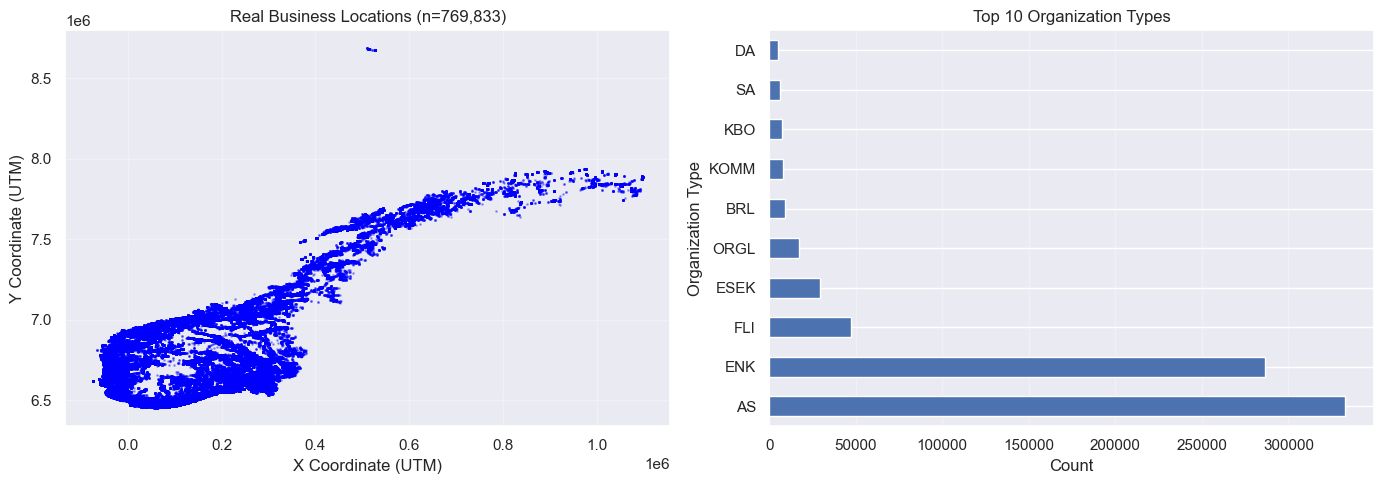

In [12]:
# Geographic distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot of locations
axes[0].scatter(df_features['X_2025'], df_features['Y_2025'], 
                alpha=0.3, s=1, c='blue')
axes[0].set_xlabel('X Coordinate (UTM)')
axes[0].set_ylabel('Y Coordinate (UTM)')
axes[0].set_title(f'Real Business Locations (n={len(df_features):,})')
axes[0].grid(True, alpha=0.3)

# Organization type distribution
df_features['orgf2025'].value_counts().head(10).plot(kind='barh', ax=axes[1])
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Organization Type')
axes[1].set_title('Top 10 Organization Types')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 5. Generate Synthetic Data

We'll test the full pipeline in the notebook by:
1. Configuring the DPMM-MST synthesizer
2. Fitting on real data
3. Generating synthetic data

In [31]:
# Configure DPMM-MST synthesizer
method_config = DPMMMSTConfig(
    epsilon=1.0,      # Privacy budget (higher = less noise)
    delta=1e-5,       # Privacy failure probability
    proc_epsilon=0.1  # Processing epsilon
)

print("Synthesizer Configuration:")
print(f"  Privacy: ε={method_config.epsilon}, δ={method_config.delta}")
print(f"  Processing ε={method_config.proc_epsilon}")

# Create synthesizer
synthesizer = DPMMMSTSynthesizer(method_config)

# Fit on real data (the synthesizer will show progress)
synthesizer.fit(df_features, domain)

# Generate synthetic data (the synthesizer will show progress)
n_synthetic = 100000  # Generate fewer synthetic records than real (faster)
df_synth = synthesizer.generate(n_synthetic, random_state=42)

# Quick sanity check
print("\nSynthetic Data Sample:")
print("=" * 60)
df_synth.head()

Synthesizer Configuration:
  Privacy: ε=1.0, δ=1e-05
  Processing ε=0.1

🚀 Starting DPMM-MST Training
Dataset: 769,833 records × 4 features
Privacy: ε=1.0, δ=1e-05
Processing ε=0.1

This may take 10-30 minutes with large datasets...

⏳ Step 1/3: Initializing DPMM-MST pipeline...
   ✓ Pipeline initialized

⏳ Step 2/3: Processing data and building privacy mechanisms...
   (This step includes binning, encoding, and DP noise addition)


PrivacyLeakage: No categorical domain provided for Column SN2025 - will be imputed.
PrivacyLeakage: No categorical domain provided for Column orgf2025 - will be imputed.



✓ Step 3/3: Training complete!

✅ DPMM-MST training finished in 51.5 seconds (0.9 minutes)


🎲 Generating Synthetic Data
Target: 100,000 synthetic records
Random state: 42

⏳ Sampling from trained model...

✅ Generation complete in 0.2 seconds
   Generated: 100,000 records × 4 features


Synthetic Data Sample:


,SN2025,orgf2025,X_2025,Y_2025
0,59.200,DA,264772.491686,6.755896e+06
1,49.320,ENK,327303.089977,7.107403e+06
2,41.200,ENK,293315.600155,6.658057e+06
3,68.209,AS,-54784.396967,6.594122e+06
4,68.209,AS,-33613.040387,6.559515e+06


### 5.1 Debug: Check Synthetic Data

In [32]:
# Detailed comparison of real vs synthetic
print("=" * 80)
print("DATA COMPARISON")
print("=" * 80)

print(f"\n1. SHAPES:")
print(f"   Real: {df_features.shape}")
if 'df_synth' in locals():
    print(f"   Synthetic: {df_synth.shape}")
else:
    print(f"   Synthetic: Not generated yet")
    print("\n⚠️ Run the synthesis cell first!")

if 'df_synth' not in locals():
    print("\nSkipping detailed comparison - no synthetic data available")
else:
    print(f"\n2. COLUMNS:")
    print(f"   Real: {df_features.columns.tolist()}")
    print(f"   Synthetic: {df_synth.columns.tolist()}")
    print(f"   Missing in synthetic: {set(df_features.columns) - set(df_synth.columns)}")

    print(f"\n3. DATA TYPES:")
    print(f"\n   Real:")
    for col in df_features.columns:
        print(f"      {col}: {df_features[col].dtype}")
    print(f"\n   Synthetic:")
    for col in df_synth.columns:
        print(f"      {col}: {df_synth[col].dtype}")

    print(f"\n4. VALUE RANGES:")
    for col in df_synth.columns:
        if col in df_features.columns:
            real_range = (df_features[col].min(), df_features[col].max())
            synth_range = (df_synth[col].min(), df_synth[col].max())
            print(f"   {col}:")
            print(f"      Real:      [{real_range[0]}, {real_range[1]}]")
            print(f"      Synthetic: [{synth_range[0]}, {synth_range[1]}]")

    print(f"\n5. SAMPLE VALUES:")
    print(f"\n   Real (first 5):")
    print(df_features.head())
    print(f"\n   Synthetic (first 5):")
    print(df_synth.head())

    print(f"\n6. CATEGORICAL DISTRIBUTIONS:")
    for col in ['orgf2025', 'SN2025']:
        if col in df_synth.columns:
            print(f"\n   {col} - Top 5 categories:")
            print(f"      Real:")
            print(df_features[col].value_counts().head())
            print(f"      Synthetic:")
            print(df_synth[col].value_counts().head())

DATA COMPARISON

1. SHAPES:
   Real: (769833, 4)
   Synthetic: (100000, 4)

2. COLUMNS:
   Real: ['SN2025', 'orgf2025', 'X_2025', 'Y_2025']
   Synthetic: ['SN2025', 'orgf2025', 'X_2025', 'Y_2025']
   Missing in synthetic: set()

3. DATA TYPES:

   Real:
      SN2025: object
      orgf2025: object
      X_2025: float64
      Y_2025: float64

   Synthetic:
      SN2025: object
      orgf2025: object
      X_2025: float64
      Y_2025: float64

4. VALUE RANGES:
   SN2025:
      Real:      [, 99.000]
      Synthetic: [, 99.000]
   orgf2025:
      Real:      [ANNA, SÆR]
      Synthetic: [ANNA, SÆR]
   X_2025:
      Real:      [-74800.421726699, 1098271.9231262]
      Synthetic: [-64554.957948125055, 2096347.2984163577]
   Y_2025:
      Real:      [6449850.01173696, 8685966.0]
      Synthetic: [4648649.779305355, 8388599.133040758]

5. SAMPLE VALUES:

   Real (first 5):
    SN2025 orgf2025         X_2025        Y_2025
2   90.020      NUF  199000.599174  6.625211e+06
3   46.739       AS  2885

## 6. Visualize Synthetic vs Real Data

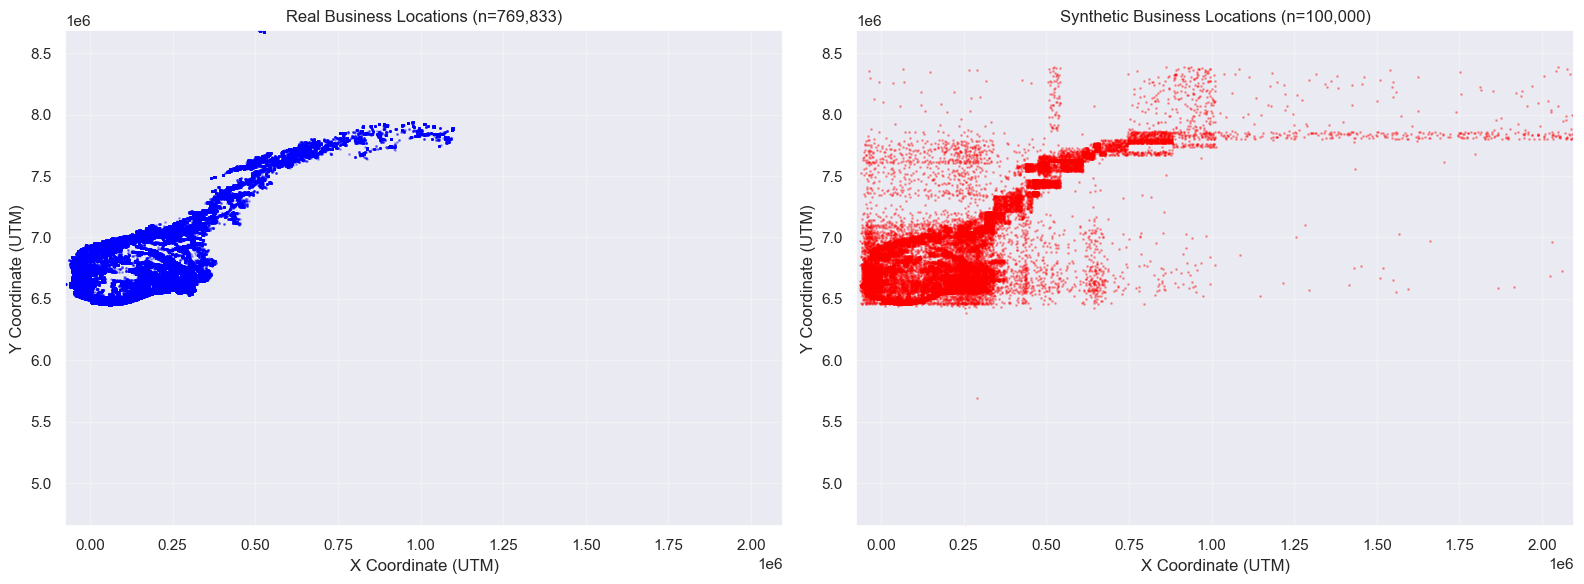


Real data coordinate ranges:
  X: [-74800, 1098272]
  Y: [6449850, 8685966]

Synthetic data coordinate ranges:
  X: [-64555, 2096347]
  Y: [4648650, 8388599]


In [47]:
# Side-by-side geographic comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Real data
axes[0].scatter(df_features['X_2025'], df_features['Y_2025'], 
                alpha=0.3, s=1, c='blue')
axes[0].set_xlabel('X Coordinate (UTM)')
axes[0].set_ylabel('Y Coordinate (UTM)')
axes[0].set_title(f'Real Business Locations (n={len(df_features):,})')
axes[0].grid(True, alpha=0.3)

# Synthetic data
axes[1].scatter(df_synth['X_2025'], df_synth['Y_2025'], 
                alpha=0.3, s=1, c='red')
axes[1].set_xlabel('X Coordinate (UTM)')
axes[1].set_ylabel('Y Coordinate (UTM)')
axes[1].set_title(f'Synthetic Business Locations (n={len(df_synth):,})')
axes[1].grid(True, alpha=0.3)

# Use same axis limits for comparison
x_min = min(df_features['X_2025'].min(), df_synth['X_2025'].min())
x_max = max(df_features['X_2025'].max(), df_synth['X_2025'].max())
y_min = min(df_features['Y_2025'].min(), df_synth['Y_2025'].min())
y_max = max(df_features['Y_2025'].max(), df_synth['Y_2025'].max())

axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Print coordinate ranges
print(f"\nReal data coordinate ranges:")
print(f"  X: [{df_features['X_2025'].min():.0f}, {df_features['X_2025'].max():.0f}]")
print(f"  Y: [{df_features['Y_2025'].min():.0f}, {df_features['Y_2025'].max():.0f}]")
print(f"\nSynthetic data coordinate ranges:")
print(f"  X: [{df_synth['X_2025'].min():.0f}, {df_synth['X_2025'].max():.0f}]")
print(f"  Y: [{df_synth['Y_2025'].min():.0f}, {df_synth['Y_2025'].max():.0f}]")

### 6.0 Define Better Plot Boundaries (Remove Outliers)

Remove extreme outliers to focus on the main geographic area and prevent distorted views.

In [40]:
# Calculate better boundaries using percentiles to exclude extreme outliers
# Use 1st and 99th percentiles to focus on main distribution
percentile_low = 1
percentile_high = 99

# Calculate bounds from real data (to define the "valid" geographic area)
x_min_clean = np.percentile(df_features['X_2025'], percentile_low)
x_max_clean = np.percentile(df_features['X_2025'], percentile_high)
y_min_clean = np.percentile(df_features['Y_2025'], percentile_low)
y_max_clean = np.percentile(df_features['Y_2025'], percentile_high)

# Add some padding for better visualization (5% on each side)
x_range = x_max_clean - x_min_clean
y_range = y_max_clean - y_min_clean
padding = 0.05

x_min_clean = x_min_clean - padding * x_range
x_max_clean = x_max_clean + padding * x_range
y_min_clean = y_min_clean - padding * y_range
y_max_clean = y_max_clean + padding * y_range

# Make the plot square by using the larger range
max_range = max(x_range, y_range) * (1 + 2 * padding)
x_center = (x_min_clean + x_max_clean) / 2
y_center = (y_min_clean + y_max_clean) / 2

x_min_clean = x_center - max_range / 2
x_max_clean = x_center + max_range / 2
y_min_clean = y_center - max_range / 2
y_max_clean = y_center + max_range / 2

print(f"📍 Cleaned Plot Boundaries (excluding {percentile_low}%-{100-percentile_high}% outliers):")
print(f"  X: [{x_min_clean:.0f}, {x_max_clean:.0f}]")
print(f"  Y: [{y_min_clean:.0f}, {y_max_clean:.0f}]")
print(f"\n  Original bounds:")
print(f"  X: [{df_features['X_2025'].min():.0f}, {df_features['X_2025'].max():.0f}]")
print(f"  Y: [{df_features['Y_2025'].min():.0f}, {df_features['Y_2025'].max():.0f}]")

# Count how many points are outside bounds
real_outside = ((df_features['X_2025'] < x_min_clean) | (df_features['X_2025'] > x_max_clean) |
                (df_features['Y_2025'] < y_min_clean) | (df_features['Y_2025'] > y_max_clean)).sum()
synth_outside = ((df_synth['X_2025'] < x_min_clean) | (df_synth['X_2025'] > x_max_clean) |
                 (df_synth['Y_2025'] < y_min_clean) | (df_synth['Y_2025'] > y_max_clean)).sum()

print(f"\n  Points outside cleaned bounds:")
print(f"  Real: {real_outside:,} ({100*real_outside/len(df_features):.1f}%)")
print(f"  Synthetic: {synth_outside:,} ({100*synth_outside/len(df_synth):.1f}%)")
print(f"\n💡 All subsequent maps will use these cleaned boundaries for better visualization")

📍 Cleaned Plot Boundaries (excluding 1%-1% outliers):
  X: [-350223, 1120097]
  Y: [6398763, 7869083]

  Original bounds:
  X: [-74800, 1098272]
  Y: [6449850, 8685966]

  Points outside cleaned bounds:
  Real: 2,977 (0.4%)
  Synthetic: 684 (0.7%)

💡 All subsequent maps will use these cleaned boundaries for better visualization


### 6.0.1 Create Plotting Subsets (for faster visualization)

Sample data for plotting to avoid overcrowding maps and improve performance.

In [48]:
# Create subsets for plotting (much faster and clearer visualization)
n_plot = 10000  # Number of points to show in maps

# Sample real data for plotting
if len(df_features) > n_plot:
    df_features_plot = df_features.sample(n=n_plot, random_state=42)
    print(f"📊 Real data: Using {n_plot:,} samples for plotting (from {len(df_features):,} total)")
else:
    df_features_plot = df_features
    print(f"📊 Real data: Using all {len(df_features):,} points for plotting")

# Sample synthetic data for plotting
if len(df_synth) > n_plot:
    df_synth_plot = df_synth.sample(n=n_plot, random_state=42)
    print(f"📊 Synthetic data: Using {n_plot:,} samples for plotting (from {len(df_synth):,} total)")
else:
    df_synth_plot = df_synth
    print(f"📊 Synthetic data: Using all {len(df_synth):,} points for plotting")

print(f"\n💡 To plot more/fewer points, adjust n_plot above")
print(f"💡 Statistical analyses will still use all {len(df_features):,} real and {len(df_synth):,} synthetic records")

📊 Real data: Using 10,000 samples for plotting (from 769,833 total)
📊 Synthetic data: Using 10,000 samples for plotting (from 100,000 total)

💡 To plot more/fewer points, adjust n_plot above
💡 Statistical analyses will still use all 769,833 real and 100,000 synthetic records


### 6.1 Geographic Distribution by Industry Type (SN2025)

Visualize how different industries are distributed spatially. This shows if the synthesizer preserves industry clustering patterns (e.g., retail in urban centers, manufacturing in industrial zones).

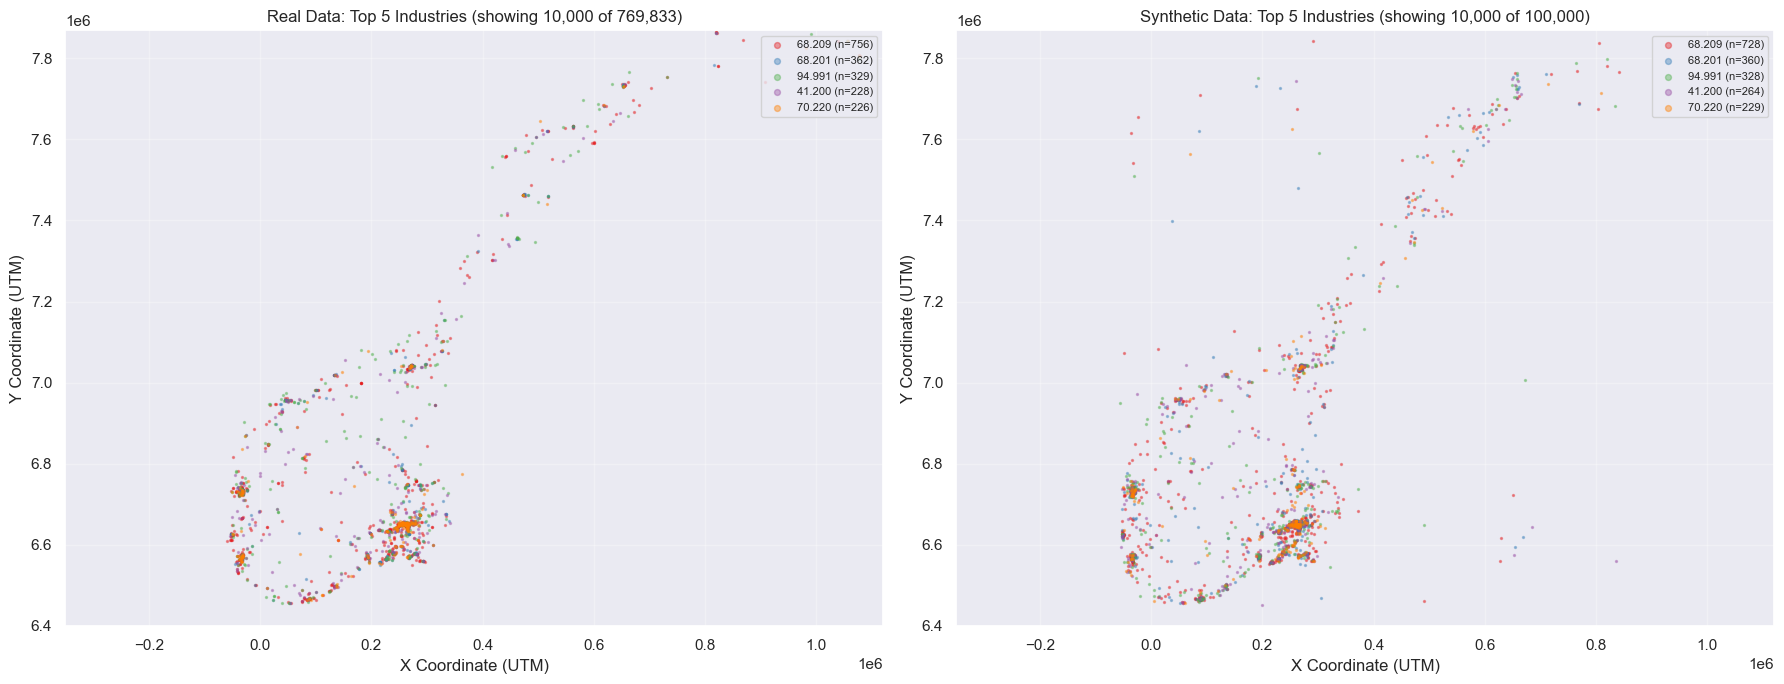


📊 Industry Spatial Analysis:

Top 5 Industries:
1. 68.209:
   Real: 56,374 (7.3%) | Synthetic: 7,311 (7.3%)
2. 68.201:
   Real: 27,541 (3.6%) | Synthetic: 3,570 (3.6%)
3. 94.991:
   Real: 25,500 (3.3%) | Synthetic: 3,308 (3.3%)
4. 41.200:
   Real: 19,749 (2.6%) | Synthetic: 2,565 (2.6%)
5. 70.220:
   Real: 18,813 (2.4%) | Synthetic: 2,437 (2.4%)

💡 Check if spatial clustering patterns are similar between real and synthetic


In [49]:
# Get top 5 most common industries (from full dataset)
top_industries = df_features['SN2025'].value_counts().head(5).index.tolist()

# Create color map for top industries
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
industry_colors = {ind: colors[i] for i, ind in enumerate(top_industries)}

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Real data - color by industry (using plotting subset)
for industry in top_industries:
    mask_real = df_features_plot['SN2025'] == industry
    axes[0].scatter(
        df_features_plot.loc[mask_real, 'X_2025'], 
        df_features_plot.loc[mask_real, 'Y_2025'],
        alpha=0.4, s=2, c=industry_colors[industry], 
        label=f'{industry} (n={mask_real.sum():,})'
    )

axes[0].set_xlabel('X Coordinate (UTM)')
axes[0].set_ylabel('Y Coordinate (UTM)')
axes[0].set_title(f'Real Data: Top 5 Industries (showing {len(df_features_plot):,} of {len(df_features):,})')
axes[0].legend(loc='upper right', fontsize=8, markerscale=3)
axes[0].grid(True, alpha=0.3)

# Synthetic data - color by industry (using plotting subset)
for industry in top_industries:
    mask_synth = df_synth_plot['SN2025'] == industry
    axes[1].scatter(
        df_synth_plot.loc[mask_synth, 'X_2025'], 
        df_synth_plot.loc[mask_synth, 'Y_2025'],
        alpha=0.4, s=2, c=industry_colors[industry],
        label=f'{industry} (n={mask_synth.sum():,})'
    )

axes[1].set_xlabel('X Coordinate (UTM)')
axes[1].set_ylabel('Y Coordinate (UTM)')
axes[1].set_title(f'Synthetic Data: Top 5 Industries (showing {len(df_synth_plot):,} of {len(df_synth):,})')
axes[1].legend(loc='upper right', fontsize=8, markerscale=3)
axes[1].grid(True, alpha=0.3)

# Use cleaned axis limits (excludes outliers)
axes[0].set_xlim(x_min_clean, x_max_clean)
axes[0].set_ylim(y_min_clean, y_max_clean)
axes[1].set_xlim(x_min_clean, x_max_clean)
axes[1].set_ylim(y_min_clean, y_max_clean)

plt.tight_layout()
plt.show()

print("\n📊 Industry Spatial Analysis:")
print("=" * 70)
print("\nTop 5 Industries:")
for i, industry in enumerate(top_industries, 1):
    real_count = (df_features['SN2025'] == industry).sum()
    synth_count = (df_synth['SN2025'] == industry).sum()
    real_pct = 100 * real_count / len(df_features)
    synth_pct = 100 * synth_count / len(df_synth)
    print(f"{i}. {industry}:")
    print(f"   Real: {real_count:,} ({real_pct:.1f}%) | Synthetic: {synth_count:,} ({synth_pct:.1f}%)")
print("\n💡 Check if spatial clustering patterns are similar between real and synthetic")

### 6.2 Geographic Distribution by Organization Type (orgf2025)

Visualize how different organization forms (AS, ENK, ASA, etc.) are distributed spatially. This reveals if the synthesizer maintains patterns like sole proprietorships (ENK) in rural areas vs corporations (AS) in urban centers.

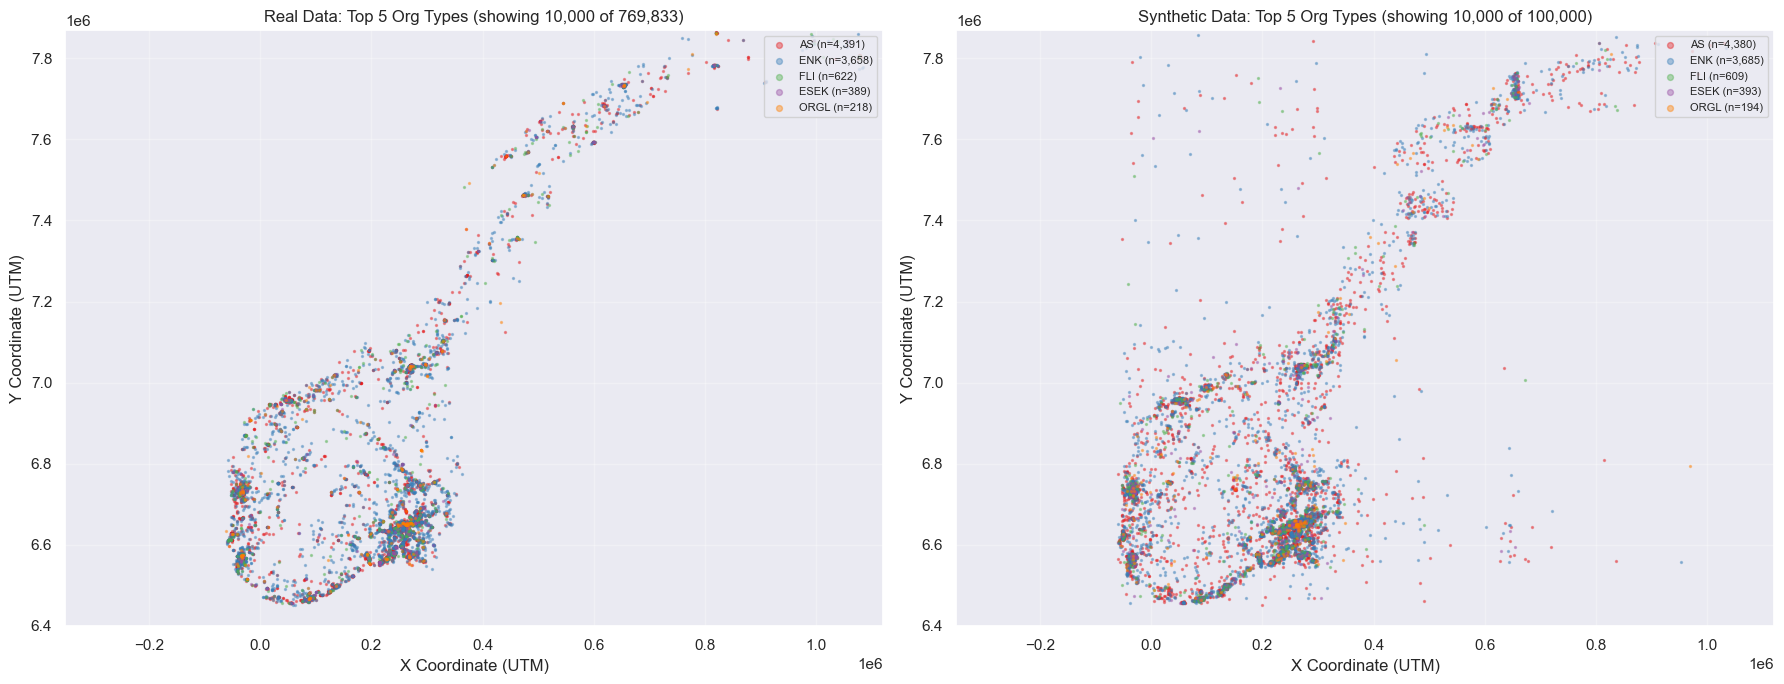


📊 Organization Type Spatial Analysis:

Top 5 Organization Types:
1. AS:
   Real: 332,786 (43.2%) | Synthetic: 43,319 (43.3%)
2. ENK:
   Real: 286,378 (37.2%) | Synthetic: 37,085 (37.1%)
3. FLI:
   Real: 47,206 (6.1%) | Synthetic: 6,104 (6.1%)
4. ESEK:
   Real: 29,557 (3.8%) | Synthetic: 3,835 (3.8%)
5. ORGL:
   Real: 17,048 (2.2%) | Synthetic: 2,179 (2.2%)

💡 Look for similar urban/rural patterns in organization types


In [43]:
# Get top 5 most common organization types (from full dataset)
top_orgtypes = df_features['orgf2025'].value_counts().head(5).index.tolist()

# Create color map for top org types
org_colors = {org: colors[i] for i, org in enumerate(top_orgtypes)}

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Real data - color by organization type (using plotting subset)
for orgtype in top_orgtypes:
    mask_real = df_features_plot['orgf2025'] == orgtype
    axes[0].scatter(
        df_features_plot.loc[mask_real, 'X_2025'], 
        df_features_plot.loc[mask_real, 'Y_2025'],
        alpha=0.4, s=2, c=org_colors[orgtype], 
        label=f'{orgtype} (n={mask_real.sum():,})'
    )

axes[0].set_xlabel('X Coordinate (UTM)')
axes[0].set_ylabel('Y Coordinate (UTM)')
axes[0].set_title(f'Real Data: Top 5 Org Types (showing {len(df_features_plot):,} of {len(df_features):,})')
axes[0].legend(loc='upper right', fontsize=8, markerscale=3)
axes[0].grid(True, alpha=0.3)

# Synthetic data - color by organization type (using plotting subset)
for orgtype in top_orgtypes:
    mask_synth = df_synth_plot['orgf2025'] == orgtype
    axes[1].scatter(
        df_synth_plot.loc[mask_synth, 'X_2025'], 
        df_synth_plot.loc[mask_synth, 'Y_2025'],
        alpha=0.4, s=2, c=org_colors[orgtype],
        label=f'{orgtype} (n={mask_synth.sum():,})'
    )

axes[1].set_xlabel('X Coordinate (UTM)')
axes[1].set_ylabel('Y Coordinate (UTM)')
axes[1].set_title(f'Synthetic Data: Top 5 Org Types (showing {len(df_synth_plot):,} of {len(df_synth):,})')
axes[1].legend(loc='upper right', fontsize=8, markerscale=3)
axes[1].grid(True, alpha=0.3)

# Use cleaned axis limits (excludes outliers)
axes[0].set_xlim(x_min_clean, x_max_clean)
axes[0].set_ylim(y_min_clean, y_max_clean)
axes[1].set_xlim(x_min_clean, x_max_clean)
axes[1].set_ylim(y_min_clean, y_max_clean)

plt.tight_layout()
plt.show()

print("\n📊 Organization Type Spatial Analysis:")
print("=" * 70)
print("\nTop 5 Organization Types:")
for i, orgtype in enumerate(top_orgtypes, 1):
    real_count = (df_features['orgf2025'] == orgtype).sum()
    synth_count = (df_synth['orgf2025'] == orgtype).sum()
    real_pct = 100 * real_count / len(df_features)
    synth_pct = 100 * synth_count / len(df_synth)
    print(f"{i}. {orgtype}:")
    print(f"   Real: {real_count:,} ({real_pct:.1f}%) | Synthetic: {synth_count:,} ({synth_pct:.1f}%)")
print("\n💡 Look for similar urban/rural patterns in organization types")

### 6.3 Density Heatmaps

Compare spatial density patterns between real and synthetic data using 2D histograms.

Density range: 1 to 1327 businesses per bin (log scale)
💡 Toggle use_log_scale above to switch between linear and log scale


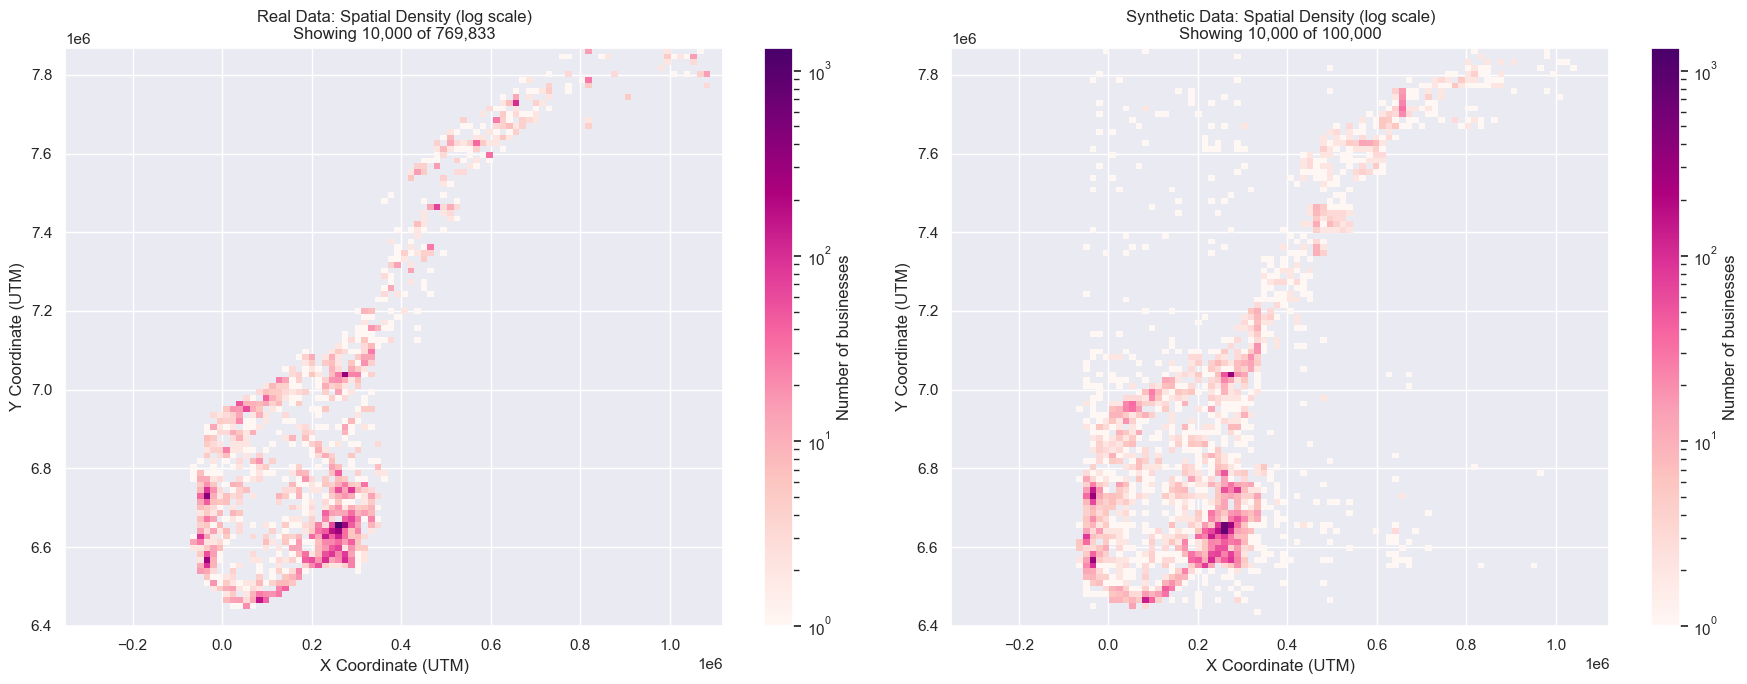


🔥 Heatmap Analysis:
Look for:
  ✓ Similar density hotspots (urban centers)
  ✓ Comparable low-density areas (rural regions)
  ✓ Overall spatial coverage matching


In [46]:
# Toggle between linear and log scale for better visibility
use_log_scale = True  # Set to False for linear scale

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Calculate histograms first to get common color scale
hist_real, xedges_real, yedges_real = np.histogram2d(
    df_features_plot['X_2025'], 
    df_features_plot['Y_2025'],
    bins=100,
    range=[[x_min_clean, x_max_clean], [y_min_clean, y_max_clean]]
)

hist_synth, xedges_synth, yedges_synth = np.histogram2d(
    df_synth_plot['X_2025'], 
    df_synth_plot['Y_2025'],
    bins=100,
    range=[[x_min_clean, x_max_clean], [y_min_clean, y_max_clean]]
)

# Get common color scale (min=1 to hide empty bins, max from both datasets)
vmin = 1
vmax = max(hist_real.max(), hist_synth.max())

# Set up normalization (linear or log)
if use_log_scale:
    from matplotlib.colors import LogNorm
    norm = LogNorm(vmin=vmin, vmax=vmax)
    scale_label = "log scale"
else:
    norm = None  # Default linear normalization
    scale_label = "linear scale"

print(f"Density range: 1 to {vmax:.0f} businesses per bin ({scale_label})")
print(f"💡 Toggle use_log_scale above to switch between linear and log scale")

# Real data heatmap (using plotting subset)
h_real = axes[0].hist2d(
    df_features_plot['X_2025'], 
    df_features_plot['Y_2025'],
    bins=100, 
    cmap='RdPu',  # Red-Purple colormap (better visibility)
    cmin=vmin if not use_log_scale else None,
    vmax=vmax if not use_log_scale else None,
    norm=norm,
    range=[[x_min_clean, x_max_clean], [y_min_clean, y_max_clean]]
)
axes[0].set_xlabel('X Coordinate (UTM)')
axes[0].set_ylabel('Y Coordinate (UTM)')
axes[0].set_title(f'Real Data: Spatial Density ({scale_label})\nShowing {len(df_features_plot):,} of {len(df_features):,}')
plt.colorbar(h_real[3], ax=axes[0], label='Number of businesses')

# Synthetic data heatmap (using plotting subset)
h_synth = axes[1].hist2d(
    df_synth_plot['X_2025'], 
    df_synth_plot['Y_2025'],
    bins=100, 
    cmap='RdPu',  # Red-Purple colormap (better visibility)
    cmin=vmin if not use_log_scale else None,
    vmax=vmax if not use_log_scale else None,
    norm=norm,
    range=[[x_min_clean, x_max_clean], [y_min_clean, y_max_clean]]
)
axes[1].set_xlabel('X Coordinate (UTM)')
axes[1].set_ylabel('Y Coordinate (UTM)')
axes[1].set_title(f'Synthetic Data: Spatial Density ({scale_label})\nShowing {len(df_synth_plot):,} of {len(df_synth):,}')
plt.colorbar(h_synth[3], ax=axes[1], label='Number of businesses')

# Use cleaned axis limits (excludes outliers)
axes[0].set_xlim(x_min_clean, x_max_clean)
axes[0].set_ylim(y_min_clean, y_max_clean)
axes[1].set_xlim(x_min_clean, x_max_clean)
axes[1].set_ylim(y_min_clean, y_max_clean)

plt.tight_layout()
plt.show()

print("\n🔥 Heatmap Analysis:")
print("=" * 70)
print("Look for:")
print("  ✓ Similar density hotspots (urban centers)")
print("  ✓ Comparable low-density areas (rural regions)")
print("  ✓ Overall spatial coverage matching")

## 7. Quantitative Evaluation

### Basic Statistics

In [27]:
stats = compare_basic_stats(df_features, df_synth)
print("Basic Statistics Comparison:")
print("=" * 60)
stats

Basic Statistics Comparison:


,real_mean,synthetic_mean,diff_mean,real_std,synthetic_std,diff_std,real_min,synthetic_min,diff_min,real_max,synthetic_max,diff_max,real_p25,synthetic_p25,diff_p25,real_p50,synthetic_p50,diff_p50,real_p75,synthetic_p75,diff_p75
column,,,,,,,,,,,,,,,,,,,,,
X_2025,2.149284e+05,2.153826e+05,454.214241,175266.135933,177135.058071,1868.922138,-7.480042e+04,-6.435271e+04,10447.716237,1.098272e+06,1.246909e+06,148637.398015,8.912098e+04,8.973782e+04,616.840078,2.541604e+05,2.535282e+05,-632.190182,2.709278e+05,2.711132e+05,185.351871
Y_2025,6.779269e+06,6.780333e+06,1063.973715,303603.530270,308021.606144,4418.075874,6.449850e+06,6.449976e+06,125.561743,8.685966e+06,8.384152e+06,-301813.693793,6.616076e+06,6.614830e+06,-1245.940896,6.652092e+06,6.651864e+06,-227.804481,6.818297e+06,6.816429e+06,-1867.879046


### Categorical Distributions

In [28]:
# Organization types
print("Organization Type Distribution:")
print("=" * 60)
cat_freq_org = compare_category_frequencies(
    df_features, df_synth, 
    column='orgf2025', 
    top_k=10
)
display(cat_freq_org)

# Industry codes (SN2025)
print("\n\nIndustry Code Distribution:")
print("=" * 60)
cat_freq_industry = compare_category_frequencies(
    df_features, df_synth, 
    column='SN2025', 
    top_k=10
)
display(cat_freq_industry)

Organization Type Distribution:


TypeError: compare_category_frequencies() got an unexpected keyword argument 'column'

### Spatial Metrics

In [29]:
# Check if spatial metrics can be computed
if 'grk2025' in df_features.columns and 'grk2025' in df_synth.columns:
    spatial_metrics = evaluate_spatial_metrics(
        df_features, df_synth,
        x_col='X_2025',
        y_col='Y_2025',
        unit_col='grk2025',
        categorical_col='orgf2025'
    )
    
    print("Spatial Quality Metrics:")
    print("=" * 60)
    print("Lower is better for divergence/distance metrics")
    print()
    display(spatial_metrics.T)
else:
    print("⚠️ Skipping spatial metrics - grk2025 not in synthetic data")
    print("   (This is expected since grk2025 was removed from features)")
    print("   To get spatial metrics, you need to reconstruct grk2025 from X/Y coordinates")

⚠️ Skipping spatial metrics - grk2025 not in synthetic data
   (This is expected since grk2025 was removed from features)
   To get spatial metrics, you need to reconstruct grk2025 from X/Y coordinates


## 8. Summary

**Pipeline Test Complete!** ✓

The notebook tests the full pipeline:
1. ✅ Config-based data loading with validation
2. ✅ Feature preparation with sampling
3. ✅ DPMM-MST synthesis with differential privacy
4. ✅ Visual comparison of spatial distributions
5. ✅ Quantitative evaluation (statistics, categories, spatial metrics)

**Next Steps:**
- Adjust privacy parameters (epsilon, delta) for different utility-privacy tradeoffs
- Test with full dataset (remove `sample_size` parameter)
- Use the runner script for production: `python src/synlab/runners/run_geostad_dpmm_mst.py`
- Experiment with different config settings (feature selection, coordinate filtering, etc.)

### Visual Comparison

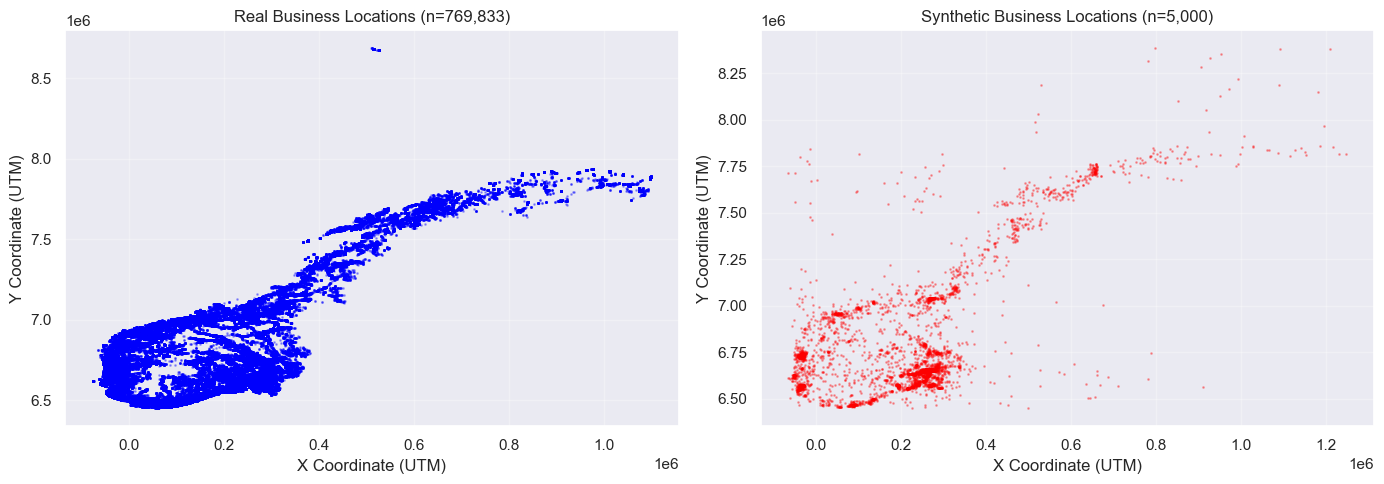

In [30]:
if 'df_synth' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Real data
    axes[0].scatter(df_features['X_2025'], df_features['Y_2025'], 
                    alpha=0.3, s=1, c='blue', label='Real')
    axes[0].set_xlabel('X Coordinate (UTM)')
    axes[0].set_ylabel('Y Coordinate (UTM)')
    axes[0].set_title(f'Real Business Locations (n={len(df_features):,})')
    axes[0].grid(True, alpha=0.3)
    
    # Synthetic data
    axes[1].scatter(df_synth['X_2025'], df_synth['Y_2025'], 
                    alpha=0.3, s=1, c='red', label='Synthetic')
    axes[1].set_xlabel('X Coordinate (UTM)')
    axes[1].set_ylabel('Y Coordinate (UTM)')
    axes[1].set_title(f'Synthetic Business Locations (n={len(df_synth):,})')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Summary

This notebook demonstrates:
1. ✓ Loading GeoSTAD business registry data with the new data loader
2. ✓ Preparing data for synthesis with feature selection
3. ✓ Generating synthetic data using DPMM-MST (via runner script)
4. ✓ Evaluating synthetic data quality with spatial metrics
5. ✓ Visualizing and comparing real vs synthetic distributions

**Next steps:**
- Experiment with different privacy budgets (epsilon values)
- Try different sample sizes for training
- Implement additional spatial evaluation metrics
- Create automated evaluation reports